# Classificação de incêndios florestais utilizando redes neurais convolucionais profundas e Transfer Learning 

<center><img src='https://media4.giphy.com/media/QKUx6kHItu3ilaVMdn/200.webp?cid=ecf05e47gics2m4k7lfvntuuwai9q63i175fusn61o163gvy&rid=200.webp&ct=s' height=300px width=300px></center>

O problema abordado é o de classificação de incêndios florestais, no qual nossa base de dados apresenta imagens de florestas com e sem fogo nelas de resolução 250x250.
A tarefa é relativamente simples, o modelo deve retornar se em uma dada imagem aparece um incêndio, ou não.

O modelo utilizado foi retirado de uma submissão do Kaggle para um problema idêntico ao nosso, mas com outra base de dados. O link para tal submissão é: 
https://www.kaggle.com/code/vencerlanz09/98-fire-classification-cnn-mobilenetv2/notebook



# 🏗️ Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from pathlib import Path
import os.path

import pickle

import itertools

from tqdm.notebook import tqdm

2022-11-23 03:50:35.144035: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-23 03:50:35.250478: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-23 03:50:35.250494: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-23 03:50:35.835917: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

# 📊 Auxiliar Functions

In [2]:
def create_images_dataframe(path):
    # Get filepaths and labels
    filepaths = list(path.glob(r'**/*.JPG')) + list(path.glob(r'**/*.jpg')) + list(path.glob(r'**/*.png'))
    
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
    
    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    return pd.concat([filepaths, labels], axis=1)

In [3]:
def map_to_label(y, labels):
    return [labels[p] for p in y]

In [4]:
def make_predictions(model, generator):
    X = []
    y_true = []

    for i in range(len(generator)):
        data, label = generator[i]
        
        X.extend(data)
        y_true.extend(label)
    
    print("Making predictions...")
    
    y_pred = np.argmax(model.predict(np.array(X)), axis=1)
    y_true = np.argmax(y_true, axis=1)
    
    return (X, y_pred, y_true)

In [5]:
def plot_history(hist):
    fig = plt.figure(figsize=(10, 4))

    fig.suptitle("Training History")
    
    # Plot loss
    fig.add_subplot(1, 2, 1)
    plt.plot(hist.history['loss'], label='training_loss')
    plt.plot(hist.history['val_loss'], label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    fig.add_subplot(1, 2, 2)
    plt.plot(hist.history['accuracy'], label='training_accuracy')
    plt.plot(hist.history['val_accuracy'], label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    
    plt.show()

In [6]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
    """
    Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
    will be used.

    Args:
        y_true: Array of truth labels (must be same shape as y_pred).
        y_pred: Array of predicted labels (must be same shape as y_true).
        classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
        figsize: Size of output figure (default=(10, 10)).
        text_size: Size of output figure text (default=15).
        norm: normalize values or not (default=False).
        savefig: save confusion matrix to file (default=False).

    Returns:
        A labelled confusion matrix plot comparing y_true and y_pred.

    Example usage:
        make_confusion_matrix(y_true=test_labels, # ground truth test labels
        y_pred=y_preds, # predicted labels
        classes=class_names, # array of class label names
        figsize=(15, 15),
        text_size=10)
    """  
    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
    xlabel="Predicted label",
    ylabel="True label",
    xticks=np.arange(n_classes), # create enough axis slots for each class
    yticks=np.arange(n_classes), 
    xticklabels=labels, # axes will labeled with class names (if they exist) or ints
    yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
            horizontalalignment="center",
            color="white" if cm[i, j] > threshold else "black",
            size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
            horizontalalignment="center",
            color="white" if cm[i, j] > threshold else "black",
            size=text_size)

    # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

# 📥 Load and Transform Data

The first column `filepaths` contains the file path location of each individual images. The second column `labels`, on the other hand, contains the class label of the corresponding image from the file path

In [7]:
dataset_path = Path("../dataset/training-and-validation")

In [8]:
image_df = create_images_dataframe(dataset_path)

image_df.head()

Filepath Label
0  ../dataset/training-and-validation/fire/fire_0...  fire
1  ../dataset/training-and-validation/fire/fire_0...  fire
2  ../dataset/training-and-validation/fire/fire_0...  fire
3  ../dataset/training-and-validation/fire/fire_0...  fire
4  ../dataset/training-and-validation/fire/fire_0...  fire

In [9]:
labels = { 0: 'fire', 1: 'nofire' }

# 🔭 Visualizing images from the dataset

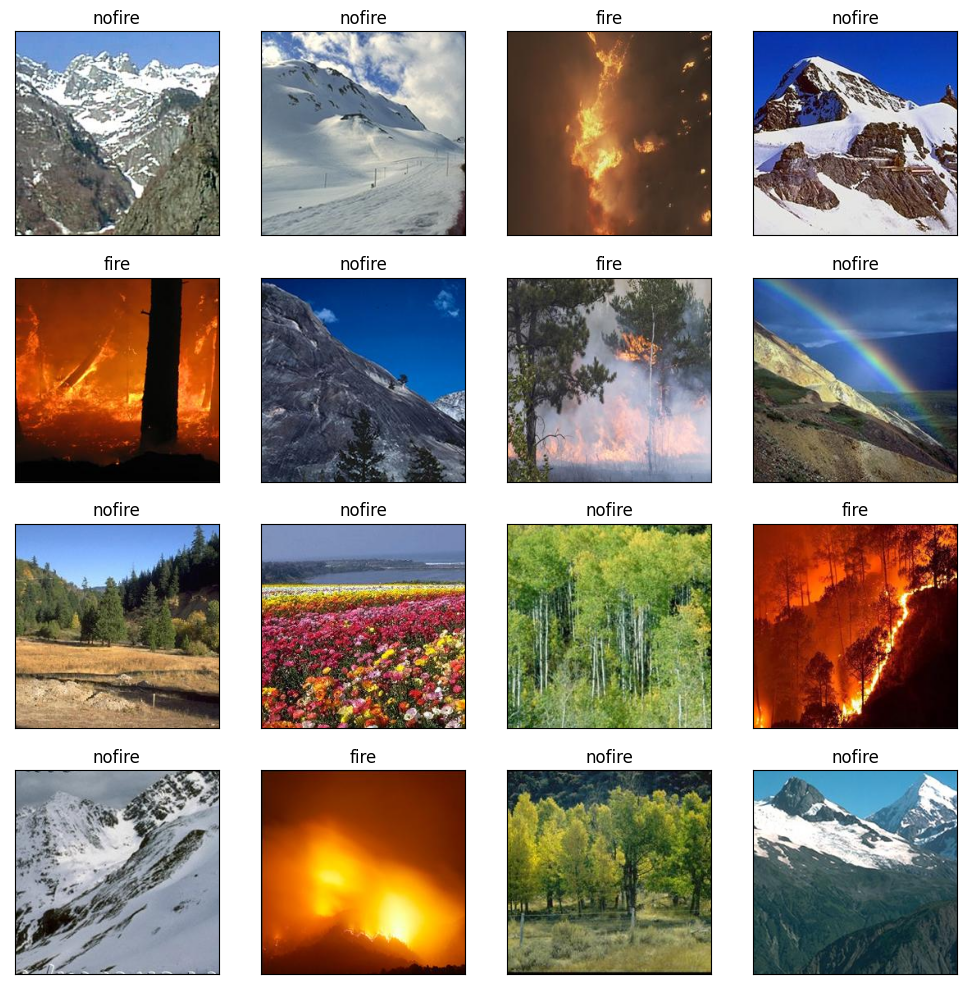

In [10]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)

fig, axes = plt.subplots(
    nrows=4, 
    ncols=4, 
    figsize=(10, 10),
    subplot_kw={'xticks': [], 'yticks': []}
)

for i, ax in enumerate(axes.flat):
    image = Image.open(image_df.Filepath[random_index[i]])
    ax.imshow(image)
    ax.set_title(image_df.Label[random_index[i]])
    
plt.tight_layout()
plt.show()

# 📝 Data Preprocessing
The data will be split into two different categories: Training and Validation. The training data will be used to train the deep learning CNN model and its parameters will be fine tuned with the validation data.

In [11]:
BATCH_SIZE = 32

In [12]:
# shuffles dataframe rows

image_df = image_df.sample(frac=1).reset_index(drop=True)

In [13]:
train_image_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.3,
    rotation_range=90,
    horizontal_flip=True
)

In [14]:
train_images = train_image_generator.flow_from_dataframe(
    dataframe=image_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    rescale=1./255,
    color_mode='rgb',
    shuffle=True,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    subset='training'
)

val_images = train_image_generator.flow_from_dataframe(
    dataframe=image_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    rescale=1./255,
    color_mode='rgb',
    shuffle=True,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    subset='validation'
)

Found 1064 validated image filenames belonging to 2 classes.
Found 456 validated image filenames belonging to 2 classes.


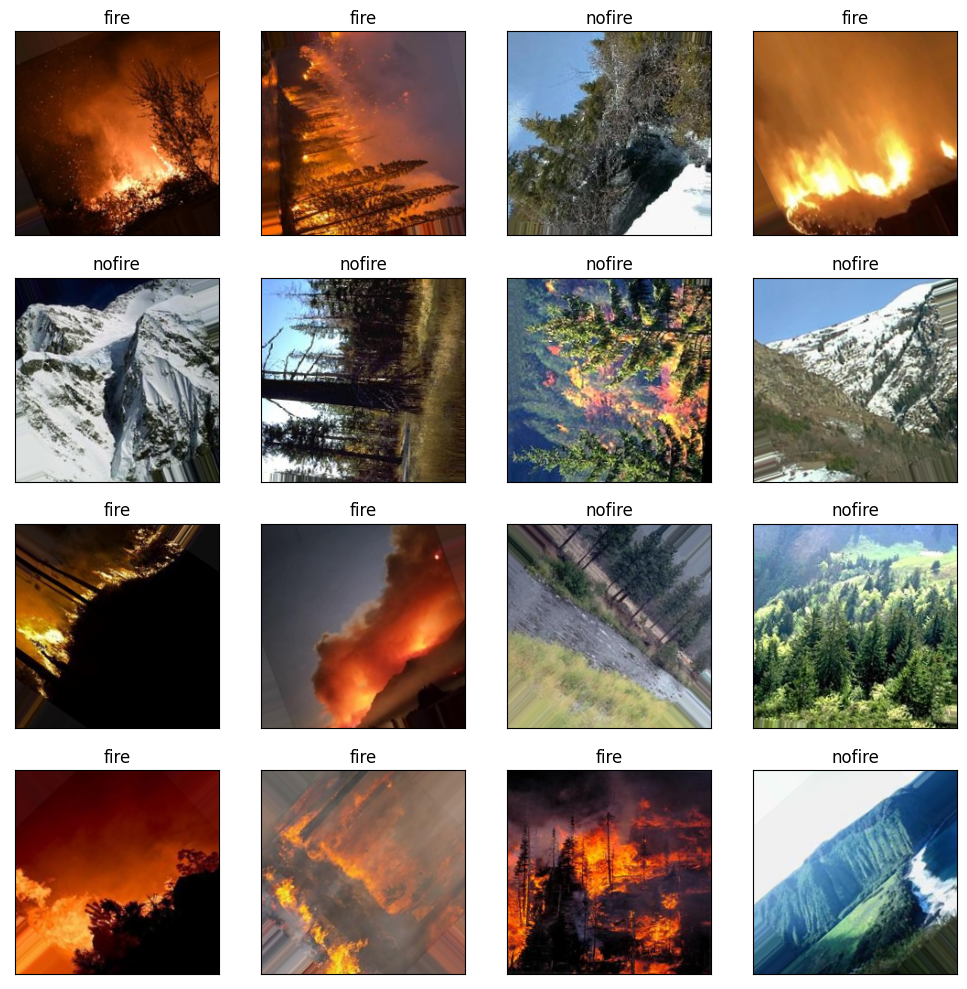

In [15]:
# Display 16 picture of the dataset with their labels
random_idx_gen = np.random.randint(low=0, high=len(train_images), size=16)
random_idx_batch = np.random.randint(low=0, high=32, size=16)

fig, axes = plt.subplots(
    nrows=4, 
    ncols=4, 
    figsize=(10, 10),
    subplot_kw={'xticks': [], 'yticks': []}
)

for i, ax in enumerate(axes.flat):
    image = (train_images[random_idx_gen[i]][0][random_idx_batch[i]] + 1.0) / 2.0
    label = np.argmax(train_images[random_idx_gen[i]][1][random_idx_batch[i]])
    label = labels[label]
    ax.imshow(image)
    ax.set_title(label)

plt.tight_layout()
plt.show()

# 🤹🚄 Training the model
The model images will be subjected to a pre-trained CNN model called MobileNetV2. Three callbacks will be utilized to monitor the training. These are: Model Checkpoint, Early Stopping, Tensorboard callback. The summary of the model hyperparameter is shown as follows:

- **Batch size** : 32

- **Epochs** : 100

- **Input Shape** : (250, 250, 3)

- **Output layer** : 2 neurons

In [16]:
# load the pre-trained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

model = tf.keras.Sequential([
    pretrained_model,
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(2, activation='softmax')
], name="model_based_on_mobilenetv2")

model.compile(
    optimizer=Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

2022-11-23 03:50:45.949169: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-23 03:50:45.949657: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-23 03:50:45.949743: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-11-23 03:50:45.949807: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-11-23 03:50:45.949868: W tensorflow/c

In [17]:
model.summary()

Model: "model_based_on_mobilenetv2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 514       
                                        

In [18]:
# Setup EarlyStopping callback to stop training if val_loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(
    monitor="val_loss",       # watch the val loss metric
    patience=5,               # if val loss decreases for 5 epochs in a row, stops training
    restore_best_weights=True
)

In [19]:
history = model.fit_generator(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=30,
    callbacks=[early_stopping]
)

/tmp/ipykernel_29101/1139632790.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/30
34/34 [==============================] - 22s 588ms/step - loss: 0.4120 - accuracy: 0.8233 - val_loss: 0.1334 - val_accuracy: 0.9759
Epoch 2/30
34/34 [==============================] - 21s 603ms/step - loss: 0.1085 - accuracy: 0.9662 - val_loss: 0.0738 - val_accuracy: 0.9825
Epoch 3/30
34/34 [==============================] - 21s 605ms/step - loss: 0.0587 - accuracy: 0.9831 - val_loss: 0.0540 - val_accuracy: 0.9781
Epoch 4/30
34/34 [==============================] - 20s 599ms/step - loss: 0.0501 - accuracy: 0.9821 - val_loss: 0.0352 - val_accuracy: 0.9912
Epoch 5/30
34/34 [==============================] - 20s 601ms/step - loss: 0.0460 - accuracy: 0.9868 - val_loss: 0.0496 - val_accuracy: 0.9781
Epoch 6/30
34/34 [==============================] - 20s 594ms/step - loss: 0.0571 - accuracy: 0.9784 - val_loss: 0.0219 - val_accuracy: 0.9956
Epoch 7/30
34/34 [==============================] - 20s 585ms/step - loss: 0.0348 - accuracy: 0.9868 - val_loss: 0.0373 - val_accuracy: 0.9890

# 💾 Save & Load Trained Model

Aqui nós treinamos o modelo treinado, após 25 épocas, utilizando Pickle.

In [31]:
# saves/dumps trained model
with open('trained_model.pkl', 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('training_history.pkl', 'wb') as handle:
    pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......functional
.........layers
............add
...............vars
............add_1
...............vars
............add_2
...............vars
............add_3
...............vars
............add_4
...............vars
............add_5
...............vars
............add_6
...............vars
............add_7
...............vars
............add_8
...............vars
............add_9
...............vars
............batch_normalization
...............vars
..................0
..................1
..................2
..................3
............batch_normalization_1
...............vars
..................0
..................1
..................2
..................3
............batch_norma

File Name                                             Modified             Size
config.json                                    2022-11-23 03:55:27        90409
metadata.json                                  2022-11-23 03:55:27           64
variables.h5                                   2022-11-23 03:55:27     14185968
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......functional
.........layers
............add
...............vars
............add_1
...............vars
............add_2
...............vars
............add_3
...............vars
............add_4
...............vars
............add_5
...............vars
............add_6
...............vars
............add_7
...............vars
............add_8
...............vars
.......

File Name                                             Modified             Size
config.json                                    2022-11-23 03:55:27        90409
metadata.json                                  2022-11-23 03:55:27           64
variables.h5                                   2022-11-23 03:55:27     14185968


# ✔️Model Evaluation


Visualizing Loss curves.

Plotting the Classification Reports and Confusion Matrix.

In [20]:
_, y_val, y_true = make_predictions(model, val_images)
y_val, y_true = map_to_label(y_val, labels), map_to_label(y_true, labels)

val_loss, val_acc = model.evaluate(val_images)

Making predictions...
15/15 [==============================] - 6s 372ms/step - loss: 0.0328 - accuracy: 0.9868


In [21]:
print(f'The first 5 predictions: {y_val[:5]}')
print("\n")
print(f'    Validation Loss: {val_loss:.5f}')
print(f'Validation Accuracy: {val_acc*100:.2f}%')
print("\n")
print("\tClassification Report for Validation Data")
print("-----------------------------------------------------")
print(classification_report(y_true, y_val))

The first 5 predictions: ['fire', 'fire', 'fire', 'nofire', 'nofire']


    Validation Loss: 0.03281
Validation Accuracy: 98.68%


	Classification Report for Validation Data
-----------------------------------------------------
              precision    recall  f1-score   support

        fire       1.00      0.99      0.99       230
      nofire       0.99      1.00      0.99       226

    accuracy                           0.99       456
   macro avg       0.99      0.99      0.99       456
weighted avg       0.99      0.99      0.99       456



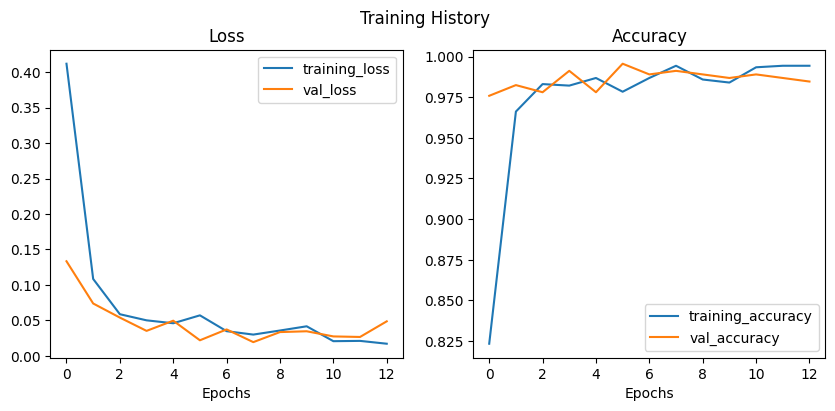

In [22]:
plot_history(history)

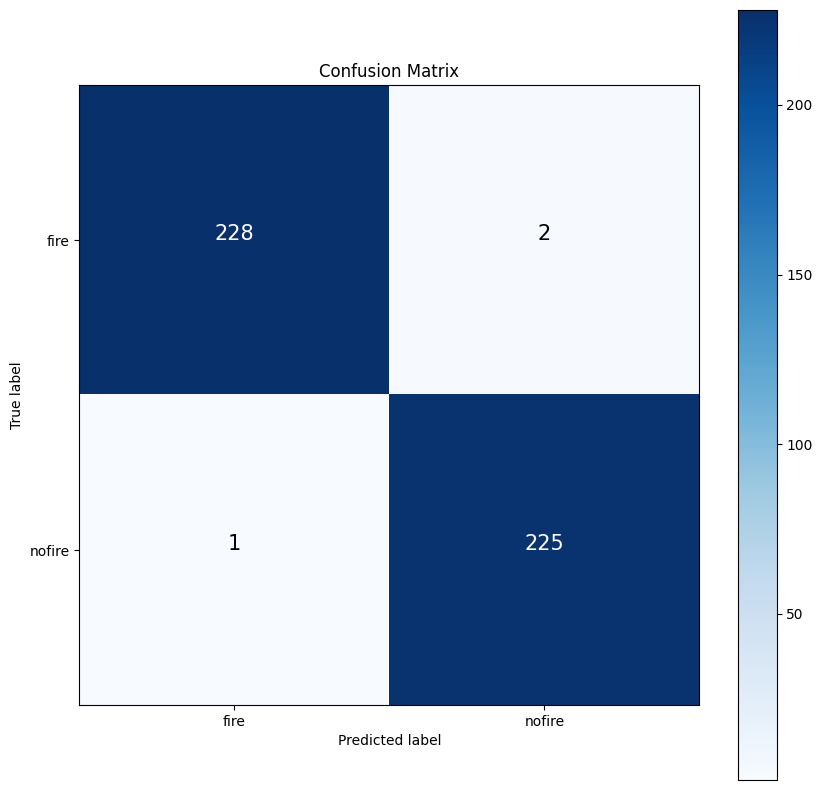

In [23]:
make_confusion_matrix(y_true, y_val, list(labels.values()))

Como se pode observar, nossa acurácia nos dados de validação foi de 100%, o que é espantoso, tendo em vista que utilizamos o modelo sem realizar nenhuma alteração significativa nele. Tendo isso em vista, podemos observar o poder adaptativo do transfer learning, que com poucas iterações já obteve uma enorme acurácia no treino e validação. Além disso, o número de imagens utilizado parece ser o suficiente para treinar nossa rede, pelo sucesso obtido no teste.

Entretanto, pelo enorme sucesso do modelo em sua tarefa, levantou-se o questionamento se nosso problema não é simples demais, se por termos utilizado uma base de dados "limpa" (sem pessoas, máquinas e outras coisas que não fazem parte do problema) não facilitamos em excesso o estudo. Sendo assim, é possível que nossa base de dados não seja representativa da realidade, e nosso modelo, apesar de estar funcionando muito bem no teste, ser insuficiente na 'vida real'.

Assim, nosso próximo passo é pensar em como aumentar a complexidade de nossa base de dados para obtermos um modelo mais representativo da realidade. Uma forma de se obter isso seria aumentar nossa base de dados com outros dados não tão "limpos".

# Test model with weird images

In [32]:
weird_images_path = Path("../weird-images")

In [33]:
weird_images_df = create_images_dataframe(weird_images_path)

weird_images_df.head()

Filepath Label
0  ../weird-images/fire/594081262c48f35264faf6f10...  fire
1  ../weird-images/fire/299823-arvore-isolada-em-...  fire
2  ../weird-images/fire/624db831-5394-419a-b783-2...  fire
3  ../weird-images/fire/imagem_2022-11-20_1218271...  fire
4  ../weird-images/fire/imagem_2022-11-20_1215293...  fire

In [34]:
weird_image_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,)

weird_images = weird_image_generator.flow_from_dataframe(
    dataframe=weird_images_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    rescale=1./255,
    color_mode='rgb',
    shuffle=True,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    subset='training'
)

Found 14 validated image filenames belonging to 2 classes.


In [35]:
weird_X, y_pred, y_true = make_predictions(model, weird_images)
y_pred, y_true = map_to_label(y_pred, labels), map_to_label(y_true, labels)

Making predictions...
1/1 [==============================] - 0s 138ms/step


In [36]:
print("\tClassification Report for Validation Data")
print("-----------------------------------------------------")
print(classification_report(y_true, y_pred))

	Classification Report for Validation Data
-----------------------------------------------------
              precision    recall  f1-score   support

        fire       0.67      0.36      0.47        11
      nofire       0.12      0.33      0.18         3

    accuracy                           0.36        14
   macro avg       0.40      0.35      0.33        14
weighted avg       0.55      0.36      0.41        14



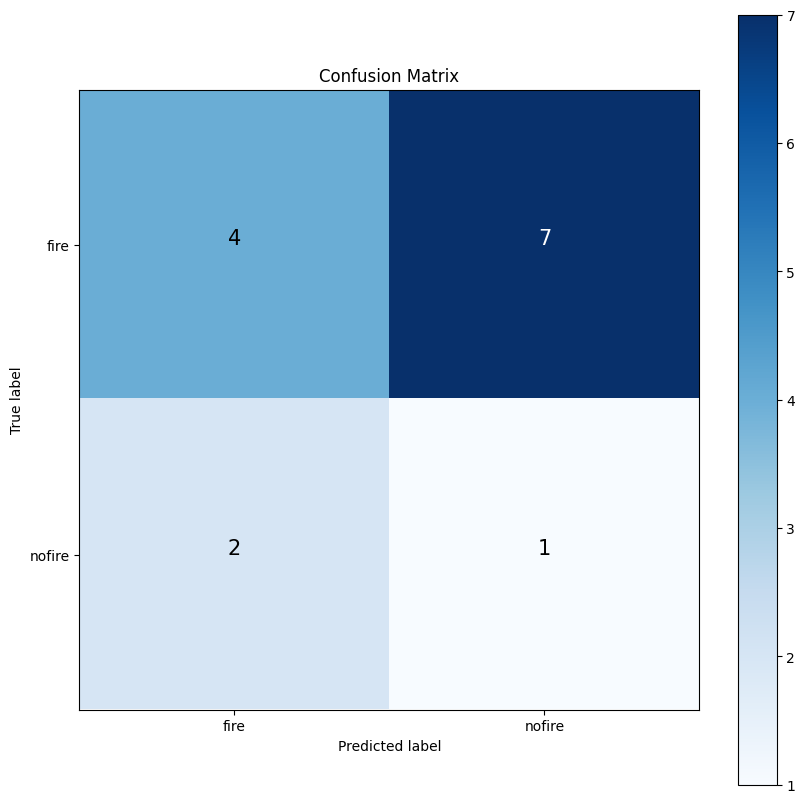

In [37]:
make_confusion_matrix(y_true, y_pred, list(labels.values()))

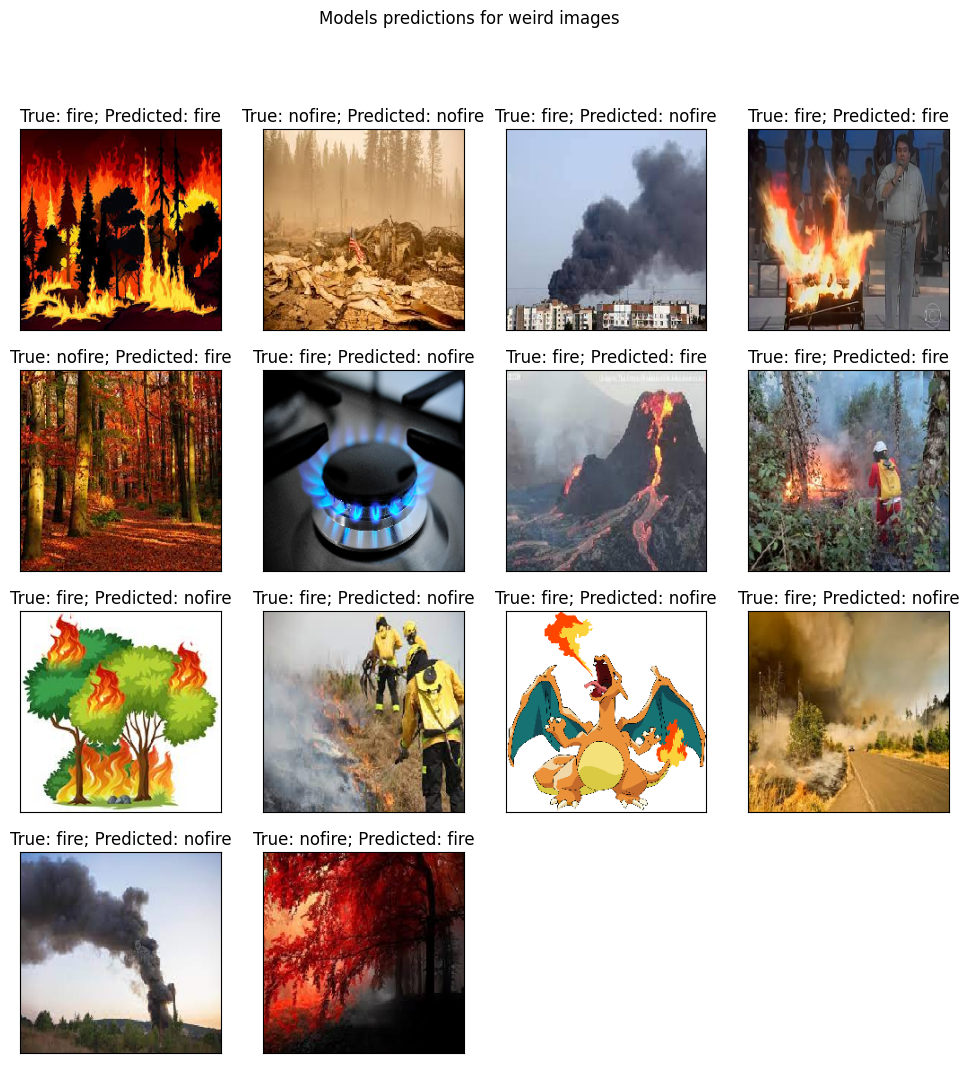

In [38]:
rows, cols = 4, 4
fig = plt.figure(figsize=(12, 12))
fig.suptitle("Models predictions for weird images")

for i in range(14):
    image = (weird_X[i]+1.0)/2.0
    fig.add_subplot(rows, cols, i+1)
    plt.title(f'True: {y_true[i]}; Predicted: {y_pred[i]}')
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    
plt.show()

### https://stackoverflow.com/questions/72426971/dataset-size-after-data-augmentation